<a href="https://colab.research.google.com/github/khataei/PE-classification-DeepLearning/blob/master/Tunned-1-CNN-activity-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Activity Classifier

In this notebook, we build a CNN neural net to classify PE activity.

#### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint 
import os  
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


import kerastuner as kt
import IPython

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/cnn2'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency

# pooling layer parameters
maxpooling_pool_size = 2
avepooling_pool_size = 2


# convolutional layer architecture:
n_conv_1 = 256 # filters, a.k.a. kernels
k_conv_1 = 3 # kernel length
n_conv_2 = 256
k_conv_2 = 3 # kernel length
n_conv_3 = 256 # filters, a.k.a. kernels
k_conv_3 = 2 # kernel length

# dense layer architecture: 
n_dense_1 = 512
dropout_1 = 0.3
n_dense_2 = 256
dropout_2 = 0.25

# training:
epochs = 60
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [3]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [4]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [5]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
labels_array_int

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note: to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [6]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
y.shape

(64754, 6)

In [7]:
input_shape = list(accel_array.shape)
input_shape

[64754, 90, 3]

### Splitting and shuffeling the data

In [8]:
# split and shuffle
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [9]:
# a conv model!

model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation='relu', input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation='relu'))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation='relu'))
# model.add(GlobalMaxPooling1D())
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense_1, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation='relu'))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

#### Configure model

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [11]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [12]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [13]:
model.fit(X_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(X_valid, y_valid), 
         callbacks=[modelcheckpoint])

# model.fit(x_train, y_train, 
#           batch_size=batch_size, epochs=epochs, verbose=1, 
#           validation_data=(x_valid, y_valid))

Epoch 1/60
228/228 [==============================] - ETA: 0s - loss: 1.7915 - accuracy: 0.15 - ETA: 4s - loss: 1.7625 - accuracy: 0.17 - ETA: 4s - loss: 1.7382 - accuracy: 0.20 - ETA: 4s - loss: 1.7074 - accuracy: 0.23 - ETA: 4s - loss: 1.6587 - accuracy: 0.27 - ETA: 4s - loss: 1.6163 - accuracy: 0.29 - ETA: 4s - loss: 1.5657 - accuracy: 0.31 - ETA: 4s - loss: 1.5395 - accuracy: 0.32 - ETA: 4s - loss: 1.5049 - accuracy: 0.34 - ETA: 4s - loss: 1.4804 - accuracy: 0.35 - ETA: 4s - loss: 1.4567 - accuracy: 0.36 - ETA: 4s - loss: 1.4334 - accuracy: 0.37 - ETA: 4s - loss: 1.4300 - accuracy: 0.37 - ETA: 4s - loss: 1.4141 - accuracy: 0.38 - ETA: 4s - loss: 1.3931 - accuracy: 0.39 - ETA: 4s - loss: 1.3751 - accuracy: 0.40 - ETA: 4s - loss: 1.3598 - accuracy: 0.41 - ETA: 4s - loss: 1.3504 - accuracy: 0.41 - ETA: 3s - loss: 1.3377 - accuracy: 0.42 - ETA: 3s - loss: 1.3253 - accuracy: 0.42 - ETA: 3s - loss: 1.3192 - accuracy: 0.43 - ETA: 3s - loss: 1.3095 - accuracy: 0.43 - ETA: 3s - loss: 1.3013

228/228 [==============================] - ETA: 2s - loss: 0.5076 - accuracy: 0.81 - ETA: 4s - loss: 0.4851 - accuracy: 0.82 - ETA: 4s - loss: 0.4821 - accuracy: 0.82 - ETA: 4s - loss: 0.5008 - accuracy: 0.81 - ETA: 4s - loss: 0.5361 - accuracy: 0.79 - ETA: 4s - loss: 0.5487 - accuracy: 0.78 - ETA: 4s - loss: 0.5560 - accuracy: 0.78 - ETA: 4s - loss: 0.5442 - accuracy: 0.78 - ETA: 4s - loss: 0.5452 - accuracy: 0.79 - ETA: 4s - loss: 0.5351 - accuracy: 0.79 - ETA: 4s - loss: 0.5318 - accuracy: 0.79 - ETA: 4s - loss: 0.5365 - accuracy: 0.79 - ETA: 4s - loss: 0.5473 - accuracy: 0.79 - ETA: 4s - loss: 0.5474 - accuracy: 0.79 - ETA: 4s - loss: 0.5445 - accuracy: 0.79 - ETA: 4s - loss: 0.5381 - accuracy: 0.80 - ETA: 3s - loss: 0.5389 - accuracy: 0.80 - ETA: 3s - loss: 0.5353 - accuracy: 0.80 - ETA: 3s - loss: 0.5341 - accuracy: 0.80 - ETA: 3s - loss: 0.5312 - accuracy: 0.80 - ETA: 3s - loss: 0.5279 - accuracy: 0.80 - ETA: 3s - loss: 0.5237 - accuracy: 0.80 - ETA: 3s - loss: 0.5218 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.3222 - accuracy: 0.85 - ETA: 4s - loss: 0.3376 - accuracy: 0.86 - ETA: 4s - loss: 0.3378 - accuracy: 0.86 - ETA: 4s - loss: 0.3227 - accuracy: 0.87 - ETA: 4s - loss: 0.3118 - accuracy: 0.87 - ETA: 4s - loss: 0.3130 - accuracy: 0.87 - ETA: 4s - loss: 0.3036 - accuracy: 0.88 - ETA: 4s - loss: 0.3028 - accuracy: 0.88 - ETA: 4s - loss: 0.3036 - accuracy: 0.88 - ETA: 4s - loss: 0.3126 - accuracy: 0.88 - ETA: 4s - loss: 0.3136 - accuracy: 0.88 - ETA: 4s - loss: 0.3227 - accuracy: 0.87 - ETA: 4s - loss: 0.3340 - accuracy: 0.87 - ETA: 4s - loss: 0.3438 - accuracy: 0.86 - ETA: 4s - loss: 0.3835 - accuracy: 0.85 - ETA: 4s - loss: 0.3819 - accuracy: 0.85 - ETA: 4s - loss: 0.3767 - accuracy: 0.86 - ETA: 4s - loss: 0.3746 - accuracy: 0.86 - ETA: 3s - loss: 0.3692 - accuracy: 0.86 - ETA: 3s - loss: 0.3666 - accuracy: 0.86 - ETA: 3s - loss: 0.3662 - accuracy: 0.86 - ETA: 3s - loss: 0.3644 - accuracy: 0.86 - ETA: 3s - loss: 0.3601 - accuracy

228/228 [==============================] - ETA: 3s - loss: 0.2863 - accuracy: 0.90 - ETA: 4s - loss: 0.2857 - accuracy: 0.90 - ETA: 4s - loss: 0.2975 - accuracy: 0.89 - ETA: 4s - loss: 0.2848 - accuracy: 0.89 - ETA: 4s - loss: 0.2803 - accuracy: 0.89 - ETA: 4s - loss: 0.2780 - accuracy: 0.89 - ETA: 4s - loss: 0.2731 - accuracy: 0.89 - ETA: 4s - loss: 0.2678 - accuracy: 0.90 - ETA: 4s - loss: 0.2677 - accuracy: 0.90 - ETA: 4s - loss: 0.2721 - accuracy: 0.90 - ETA: 4s - loss: 0.2799 - accuracy: 0.89 - ETA: 4s - loss: 0.2779 - accuracy: 0.89 - ETA: 4s - loss: 0.2769 - accuracy: 0.89 - ETA: 4s - loss: 0.2772 - accuracy: 0.89 - ETA: 4s - loss: 0.2727 - accuracy: 0.89 - ETA: 4s - loss: 0.2704 - accuracy: 0.89 - ETA: 4s - loss: 0.2712 - accuracy: 0.89 - ETA: 4s - loss: 0.2734 - accuracy: 0.89 - ETA: 3s - loss: 0.2937 - accuracy: 0.89 - ETA: 3s - loss: 0.3055 - accuracy: 0.88 - ETA: 3s - loss: 0.3067 - accuracy: 0.88 - ETA: 3s - loss: 0.3067 - accuracy: 0.88 - ETA: 3s - loss: 0.3064 - accuracy

228/228 [==============================] - ETA: 3s - loss: 0.2221 - accuracy: 0.92 - ETA: 4s - loss: 0.2482 - accuracy: 0.90 - ETA: 4s - loss: 0.2340 - accuracy: 0.90 - ETA: 4s - loss: 0.2284 - accuracy: 0.90 - ETA: 4s - loss: 0.2335 - accuracy: 0.90 - ETA: 4s - loss: 0.2283 - accuracy: 0.91 - ETA: 4s - loss: 0.2277 - accuracy: 0.91 - ETA: 4s - loss: 0.2279 - accuracy: 0.91 - ETA: 4s - loss: 0.2296 - accuracy: 0.91 - ETA: 4s - loss: 0.2324 - accuracy: 0.91 - ETA: 4s - loss: 0.2328 - accuracy: 0.91 - ETA: 4s - loss: 0.2295 - accuracy: 0.91 - ETA: 4s - loss: 0.2279 - accuracy: 0.91 - ETA: 4s - loss: 0.2334 - accuracy: 0.91 - ETA: 4s - loss: 0.2654 - accuracy: 0.90 - ETA: 4s - loss: 0.2696 - accuracy: 0.90 - ETA: 3s - loss: 0.2726 - accuracy: 0.90 - ETA: 3s - loss: 0.2753 - accuracy: 0.90 - ETA: 3s - loss: 0.2740 - accuracy: 0.90 - ETA: 3s - loss: 0.2761 - accuracy: 0.90 - ETA: 3s - loss: 0.2749 - accuracy: 0.90 - ETA: 3s - loss: 0.2745 - accuracy: 0.90 - ETA: 3s - loss: 0.2731 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.2927 - accuracy: 0.89 - ETA: 4s - loss: 0.2686 - accuracy: 0.90 - ETA: 4s - loss: 0.2654 - accuracy: 0.90 - ETA: 4s - loss: 0.2660 - accuracy: 0.89 - ETA: 4s - loss: 0.2461 - accuracy: 0.90 - ETA: 4s - loss: 0.2454 - accuracy: 0.90 - ETA: 4s - loss: 0.2400 - accuracy: 0.90 - ETA: 4s - loss: 0.2397 - accuracy: 0.90 - ETA: 4s - loss: 0.2386 - accuracy: 0.90 - ETA: 4s - loss: 0.2365 - accuracy: 0.90 - ETA: 4s - loss: 0.2373 - accuracy: 0.90 - ETA: 4s - loss: 0.2403 - accuracy: 0.90 - ETA: 4s - loss: 0.2412 - accuracy: 0.90 - ETA: 4s - loss: 0.2404 - accuracy: 0.91 - ETA: 4s - loss: 0.2390 - accuracy: 0.91 - ETA: 4s - loss: 0.2361 - accuracy: 0.91 - ETA: 4s - loss: 0.2363 - accuracy: 0.91 - ETA: 3s - loss: 0.2350 - accuracy: 0.91 - ETA: 3s - loss: 0.2340 - accuracy: 0.91 - ETA: 3s - loss: 0.2336 - accuracy: 0.91 - ETA: 3s - loss: 0.2325 - accuracy: 0.91 - ETA: 3s - loss: 0.2343 - accuracy: 0.91 - ETA: 3s - loss: 0.2328 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1945 - accuracy: 0.92 - ETA: 4s - loss: 0.1935 - accuracy: 0.92 - ETA: 4s - loss: 0.1959 - accuracy: 0.92 - ETA: 4s - loss: 0.1970 - accuracy: 0.92 - ETA: 4s - loss: 0.1957 - accuracy: 0.92 - ETA: 4s - loss: 0.1973 - accuracy: 0.92 - ETA: 4s - loss: 0.2218 - accuracy: 0.92 - ETA: 4s - loss: 0.2254 - accuracy: 0.91 - ETA: 4s - loss: 0.2281 - accuracy: 0.91 - ETA: 4s - loss: 0.2252 - accuracy: 0.91 - ETA: 4s - loss: 0.2237 - accuracy: 0.91 - ETA: 4s - loss: 0.2244 - accuracy: 0.91 - ETA: 4s - loss: 0.2237 - accuracy: 0.91 - ETA: 4s - loss: 0.2217 - accuracy: 0.91 - ETA: 4s - loss: 0.2177 - accuracy: 0.91 - ETA: 4s - loss: 0.2176 - accuracy: 0.92 - ETA: 4s - loss: 0.2165 - accuracy: 0.92 - ETA: 4s - loss: 0.2161 - accuracy: 0.92 - ETA: 3s - loss: 0.2148 - accuracy: 0.92 - ETA: 3s - loss: 0.2154 - accuracy: 0.92 - ETA: 3s - loss: 0.2155 - accuracy: 0.92 - ETA: 3s - loss: 0.2150 - accuracy: 0.92 - ETA: 3s - loss: 0.2155 - accuracy

228/228 [==============================] - ETA: 3s - loss: 0.1939 - accuracy: 0.94 - ETA: 4s - loss: 0.1609 - accuracy: 0.94 - ETA: 4s - loss: 0.1600 - accuracy: 0.94 - ETA: 4s - loss: 0.1710 - accuracy: 0.93 - ETA: 4s - loss: 0.1653 - accuracy: 0.94 - ETA: 4s - loss: 0.1644 - accuracy: 0.94 - ETA: 4s - loss: 0.1655 - accuracy: 0.94 - ETA: 4s - loss: 0.1668 - accuracy: 0.94 - ETA: 4s - loss: 0.1667 - accuracy: 0.93 - ETA: 4s - loss: 0.1652 - accuracy: 0.93 - ETA: 4s - loss: 0.1636 - accuracy: 0.94 - ETA: 4s - loss: 0.1645 - accuracy: 0.94 - ETA: 4s - loss: 0.1658 - accuracy: 0.93 - ETA: 4s - loss: 0.1640 - accuracy: 0.94 - ETA: 4s - loss: 0.1632 - accuracy: 0.94 - ETA: 3s - loss: 0.1640 - accuracy: 0.93 - ETA: 3s - loss: 0.1672 - accuracy: 0.93 - ETA: 3s - loss: 0.1697 - accuracy: 0.93 - ETA: 3s - loss: 0.1703 - accuracy: 0.93 - ETA: 3s - loss: 0.1700 - accuracy: 0.93 - ETA: 3s - loss: 0.1680 - accuracy: 0.93 - ETA: 3s - loss: 0.1717 - accuracy: 0.93 - ETA: 3s - loss: 0.1718 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1507 - accuracy: 0.94 - ETA: 4s - loss: 0.1507 - accuracy: 0.94 - ETA: 4s - loss: 0.1659 - accuracy: 0.94 - ETA: 4s - loss: 0.1762 - accuracy: 0.93 - ETA: 4s - loss: 0.1709 - accuracy: 0.93 - ETA: 4s - loss: 0.1659 - accuracy: 0.93 - ETA: 4s - loss: 0.1676 - accuracy: 0.93 - ETA: 4s - loss: 0.1733 - accuracy: 0.93 - ETA: 4s - loss: 0.1719 - accuracy: 0.93 - ETA: 4s - loss: 0.1780 - accuracy: 0.93 - ETA: 4s - loss: 0.1796 - accuracy: 0.93 - ETA: 4s - loss: 0.1805 - accuracy: 0.93 - ETA: 4s - loss: 0.1783 - accuracy: 0.93 - ETA: 4s - loss: 0.1778 - accuracy: 0.93 - ETA: 4s - loss: 0.1756 - accuracy: 0.93 - ETA: 4s - loss: 0.1738 - accuracy: 0.93 - ETA: 4s - loss: 0.1736 - accuracy: 0.93 - ETA: 3s - loss: 0.1719 - accuracy: 0.93 - ETA: 3s - loss: 0.1723 - accuracy: 0.93 - ETA: 3s - loss: 0.1737 - accuracy: 0.93 - ETA: 3s - loss: 0.1737 - accuracy: 0.93 - ETA: 3s - loss: 0.1737 - accuracy: 0.93 - ETA: 3s - loss: 0.1730 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1673 - accuracy: 0.93 - ETA: 4s - loss: 0.1668 - accuracy: 0.93 - ETA: 4s - loss: 0.1713 - accuracy: 0.93 - ETA: 4s - loss: 0.1687 - accuracy: 0.93 - ETA: 4s - loss: 0.1629 - accuracy: 0.94 - ETA: 4s - loss: 0.1573 - accuracy: 0.94 - ETA: 4s - loss: 0.1562 - accuracy: 0.94 - ETA: 4s - loss: 0.1586 - accuracy: 0.94 - ETA: 4s - loss: 0.1588 - accuracy: 0.94 - ETA: 4s - loss: 0.1584 - accuracy: 0.94 - ETA: 4s - loss: 0.1589 - accuracy: 0.94 - ETA: 4s - loss: 0.1590 - accuracy: 0.94 - ETA: 4s - loss: 0.1549 - accuracy: 0.94 - ETA: 4s - loss: 0.1550 - accuracy: 0.94 - ETA: 4s - loss: 0.1528 - accuracy: 0.94 - ETA: 3s - loss: 0.1546 - accuracy: 0.94 - ETA: 3s - loss: 0.1579 - accuracy: 0.94 - ETA: 3s - loss: 0.1580 - accuracy: 0.94 - ETA: 3s - loss: 0.1580 - accuracy: 0.94 - ETA: 3s - loss: 0.1580 - accuracy: 0.94 - ETA: 3s - loss: 0.1584 - accuracy: 0.94 - ETA: 3s - loss: 0.1590 - accuracy

228/228 [==============================] - ETA: 3s - loss: 0.1815 - accuracy: 0.92 - ETA: 4s - loss: 0.1909 - accuracy: 0.93 - ETA: 4s - loss: 0.1821 - accuracy: 0.93 - ETA: 5s - loss: 0.1678 - accuracy: 0.94 - ETA: 4s - loss: 0.1692 - accuracy: 0.94 - ETA: 4s - loss: 0.1616 - accuracy: 0.94 - ETA: 4s - loss: 0.1581 - accuracy: 0.94 - ETA: 4s - loss: 0.1580 - accuracy: 0.94 - ETA: 4s - loss: 0.1543 - accuracy: 0.94 - ETA: 4s - loss: 0.1516 - accuracy: 0.94 - ETA: 4s - loss: 0.1536 - accuracy: 0.94 - ETA: 4s - loss: 0.1532 - accuracy: 0.94 - ETA: 4s - loss: 0.1515 - accuracy: 0.94 - ETA: 4s - loss: 0.1490 - accuracy: 0.94 - ETA: 4s - loss: 0.1502 - accuracy: 0.94 - ETA: 4s - loss: 0.1495 - accuracy: 0.94 - ETA: 4s - loss: 0.1485 - accuracy: 0.94 - ETA: 4s - loss: 0.1476 - accuracy: 0.94 - ETA: 3s - loss: 0.1457 - accuracy: 0.94 - ETA: 3s - loss: 0.1470 - accuracy: 0.94 - ETA: 3s - loss: 0.1478 - accuracy: 0.94 - ETA: 3s - loss: 0.1472 - accuracy: 0.94 - ETA: 3s - loss: 0.1468 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1365 - accuracy: 0.95 - ETA: 4s - loss: 0.1309 - accuracy: 0.95 - ETA: 4s - loss: 0.1254 - accuracy: 0.95 - ETA: 4s - loss: 0.1346 - accuracy: 0.95 - ETA: 4s - loss: 0.1330 - accuracy: 0.95 - ETA: 4s - loss: 0.1377 - accuracy: 0.95 - ETA: 4s - loss: 0.1430 - accuracy: 0.95 - ETA: 4s - loss: 0.1424 - accuracy: 0.95 - ETA: 4s - loss: 0.1410 - accuracy: 0.95 - ETA: 4s - loss: 0.1506 - accuracy: 0.94 - ETA: 4s - loss: 0.1471 - accuracy: 0.94 - ETA: 4s - loss: 0.1469 - accuracy: 0.94 - ETA: 4s - loss: 0.1470 - accuracy: 0.94 - ETA: 4s - loss: 0.1473 - accuracy: 0.94 - ETA: 4s - loss: 0.1476 - accuracy: 0.94 - ETA: 4s - loss: 0.1475 - accuracy: 0.94 - ETA: 3s - loss: 0.1462 - accuracy: 0.94 - ETA: 3s - loss: 0.1443 - accuracy: 0.94 - ETA: 3s - loss: 0.1444 - accuracy: 0.95 - ETA: 3s - loss: 0.1461 - accuracy: 0.94 - ETA: 3s - loss: 0.1445 - accuracy: 0.95 - ETA: 3s - loss: 0.1440 - accuracy: 0.95 - ETA: 3s - loss: 0.1446 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1362 - accuracy: 0.93 - ETA: 4s - loss: 0.1247 - accuracy: 0.94 - ETA: 4s - loss: 0.1255 - accuracy: 0.94 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.94 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1247 - accuracy: 0.95 - ETA: 4s - loss: 0.1257 - accuracy: 0.95 - ETA: 4s - loss: 0.1276 - accuracy: 0.95 - ETA: 4s - loss: 0.1263 - accuracy: 0.95 - ETA: 4s - loss: 0.1255 - accuracy: 0.95 - ETA: 4s - loss: 0.1260 - accuracy: 0.95 - ETA: 4s - loss: 0.1282 - accuracy: 0.95 - ETA: 4s - loss: 0.1268 - accuracy: 0.95 - ETA: 4s - loss: 0.1249 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1287 - accuracy: 0.95 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 3s - loss: 0.1267 - accuracy: 0.95 - ETA: 3s - loss: 0.1260 - accuracy: 0.95 - ETA: 3s - loss: 0.1319 - accuracy: 0.95 - ETA: 3s - loss: 0.1359 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1622 - accuracy: 0.95 - ETA: 4s - loss: 0.1295 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1254 - accuracy: 0.95 - ETA: 4s - loss: 0.1269 - accuracy: 0.95 - ETA: 4s - loss: 0.1222 - accuracy: 0.95 - ETA: 4s - loss: 0.1238 - accuracy: 0.95 - ETA: 4s - loss: 0.1220 - accuracy: 0.95 - ETA: 4s - loss: 0.1216 - accuracy: 0.95 - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 4s - loss: 0.1253 - accuracy: 0.95 - ETA: 4s - loss: 0.1268 - accuracy: 0.95 - ETA: 4s - loss: 0.1257 - accuracy: 0.95 - ETA: 4s - loss: 0.1271 - accuracy: 0.95 - ETA: 4s - loss: 0.1260 - accuracy: 0.95 - ETA: 4s - loss: 0.1267 - accuracy: 0.95 - ETA: 3s - loss: 0.1260 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1248 - accuracy: 0.95 - ETA: 3s - loss: 0.1260 - accuracy: 0.95 - ETA: 3s - loss: 0.1251 - accuracy: 0.95 - ETA: 3s - loss: 0.1247 - accuracy: 0.95 - ETA: 3s - loss: 0.1235 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0798 - accuracy: 0.96 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1060 - accuracy: 0.95 - ETA: 4s - loss: 0.1055 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1158 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1198 - accuracy: 0.95 - ETA: 4s - loss: 0.1193 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1198 - accuracy: 0.95 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1180 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - accuracy: 0.95 - ETA: 3s - loss: 0.1158 - accuracy: 0.95 - ETA: 3s - loss: 0.1153 - accuracy: 0.95 - ETA: 3s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1158 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1069 - accuracy: 0.96 - ETA: 4s - loss: 0.1140 - accuracy: 0.96 - ETA: 4s - loss: 0.1036 - accuracy: 0.96 - ETA: 4s - loss: 0.1041 - accuracy: 0.96 - ETA: 4s - loss: 0.1082 - accuracy: 0.96 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1144 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1162 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1134 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1133 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0949 - accuracy: 0.96 - ETA: 4s - loss: 0.0823 - accuracy: 0.97 - ETA: 4s - loss: 0.1043 - accuracy: 0.96 - ETA: 4s - loss: 0.1030 - accuracy: 0.96 - ETA: 4s - loss: 0.0995 - accuracy: 0.96 - ETA: 4s - loss: 0.1006 - accuracy: 0.96 - ETA: 4s - loss: 0.0974 - accuracy: 0.96 - ETA: 4s - loss: 0.0973 - accuracy: 0.96 - ETA: 4s - loss: 0.1004 - accuracy: 0.96 - ETA: 4s - loss: 0.0990 - accuracy: 0.96 - ETA: 4s - loss: 0.0978 - accuracy: 0.96 - ETA: 4s - loss: 0.0984 - accuracy: 0.96 - ETA: 4s - loss: 0.0995 - accuracy: 0.96 - ETA: 4s - loss: 0.1010 - accuracy: 0.96 - ETA: 4s - loss: 0.1004 - accuracy: 0.96 - ETA: 4s - loss: 0.1014 - accuracy: 0.96 - ETA: 3s - loss: 0.1032 - accuracy: 0.96 - ETA: 3s - loss: 0.1044 - accuracy: 0.96 - ETA: 3s - loss: 0.1051 - accuracy: 0.96 - ETA: 3s - loss: 0.1044 - accuracy: 0.96 - ETA: 3s - loss: 0.1046 - accuracy: 0.96 - ETA: 3s - loss: 0.1043 - accuracy: 0.96 - ETA: 3s - loss: 0.1033 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1247 - accuracy: 0.94 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1065 - accuracy: 0.96 - ETA: 4s - loss: 0.1073 - accuracy: 0.96 - ETA: 4s - loss: 0.1010 - accuracy: 0.96 - ETA: 4s - loss: 0.0929 - accuracy: 0.96 - ETA: 4s - loss: 0.0972 - accuracy: 0.96 - ETA: 4s - loss: 0.0995 - accuracy: 0.96 - ETA: 4s - loss: 0.1004 - accuracy: 0.96 - ETA: 4s - loss: 0.0986 - accuracy: 0.96 - ETA: 4s - loss: 0.0984 - accuracy: 0.96 - ETA: 4s - loss: 0.0991 - accuracy: 0.96 - ETA: 4s - loss: 0.0979 - accuracy: 0.96 - ETA: 4s - loss: 0.1004 - accuracy: 0.96 - ETA: 4s - loss: 0.1010 - accuracy: 0.96 - ETA: 4s - loss: 0.0999 - accuracy: 0.96 - ETA: 4s - loss: 0.1010 - accuracy: 0.96 - ETA: 4s - loss: 0.1004 - accuracy: 0.96 - ETA: 3s - loss: 0.1012 - accuracy: 0.96 - ETA: 3s - loss: 0.1040 - accuracy: 0.96 - ETA: 3s - loss: 0.1029 - accuracy: 0.96 - ETA: 3s - loss: 0.1019 - accuracy: 0.96 - ETA: 3s - loss: 0.1019 - accuracy

228/228 [==============================] - ETA: 3s - loss: 0.1037 - accuracy: 0.95 - ETA: 4s - loss: 0.0945 - accuracy: 0.96 - ETA: 4s - loss: 0.0906 - accuracy: 0.96 - ETA: 4s - loss: 0.0926 - accuracy: 0.96 - ETA: 4s - loss: 0.0945 - accuracy: 0.96 - ETA: 4s - loss: 0.0957 - accuracy: 0.96 - ETA: 4s - loss: 0.0986 - accuracy: 0.96 - ETA: 4s - loss: 0.1046 - accuracy: 0.96 - ETA: 4s - loss: 0.1047 - accuracy: 0.96 - ETA: 4s - loss: 0.1032 - accuracy: 0.96 - ETA: 4s - loss: 0.1028 - accuracy: 0.96 - ETA: 4s - loss: 0.0999 - accuracy: 0.96 - ETA: 4s - loss: 0.0986 - accuracy: 0.96 - ETA: 4s - loss: 0.1014 - accuracy: 0.96 - ETA: 4s - loss: 0.1005 - accuracy: 0.96 - ETA: 4s - loss: 0.1017 - accuracy: 0.96 - ETA: 3s - loss: 0.1008 - accuracy: 0.96 - ETA: 3s - loss: 0.0999 - accuracy: 0.96 - ETA: 3s - loss: 0.1001 - accuracy: 0.96 - ETA: 3s - loss: 0.0991 - accuracy: 0.96 - ETA: 3s - loss: 0.0991 - accuracy: 0.96 - ETA: 3s - loss: 0.0998 - accuracy: 0.96 - ETA: 3s - loss: 0.0991 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0689 - accuracy: 0.97 - ETA: 4s - loss: 0.0930 - accuracy: 0.96 - ETA: 4s - loss: 0.0910 - accuracy: 0.96 - ETA: 4s - loss: 0.0886 - accuracy: 0.96 - ETA: 4s - loss: 0.0939 - accuracy: 0.96 - ETA: 4s - loss: 0.0914 - accuracy: 0.96 - ETA: 4s - loss: 0.0896 - accuracy: 0.96 - ETA: 4s - loss: 0.0899 - accuracy: 0.96 - ETA: 4s - loss: 0.0899 - accuracy: 0.96 - ETA: 4s - loss: 0.0900 - accuracy: 0.96 - ETA: 4s - loss: 0.0908 - accuracy: 0.96 - ETA: 4s - loss: 0.0893 - accuracy: 0.96 - ETA: 4s - loss: 0.0903 - accuracy: 0.96 - ETA: 4s - loss: 0.0893 - accuracy: 0.96 - ETA: 4s - loss: 0.0908 - accuracy: 0.96 - ETA: 4s - loss: 0.0912 - accuracy: 0.96 - ETA: 4s - loss: 0.0920 - accuracy: 0.96 - ETA: 3s - loss: 0.0909 - accuracy: 0.96 - ETA: 3s - loss: 0.0914 - accuracy: 0.96 - ETA: 3s - loss: 0.0919 - accuracy: 0.96 - ETA: 3s - loss: 0.0917 - accuracy: 0.96 - ETA: 3s - loss: 0.0925 - accuracy: 0.96 - ETA: 3s - loss: 0.0924 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0792 - accuracy: 0.96 - ETA: 4s - loss: 0.0815 - accuracy: 0.96 - ETA: 4s - loss: 0.0849 - accuracy: 0.96 - ETA: 4s - loss: 0.0885 - accuracy: 0.96 - ETA: 4s - loss: 0.0854 - accuracy: 0.96 - ETA: 4s - loss: 0.0818 - accuracy: 0.96 - ETA: 4s - loss: 0.0814 - accuracy: 0.96 - ETA: 4s - loss: 0.0806 - accuracy: 0.96 - ETA: 4s - loss: 0.0805 - accuracy: 0.96 - ETA: 4s - loss: 0.0835 - accuracy: 0.96 - ETA: 4s - loss: 0.0821 - accuracy: 0.96 - ETA: 4s - loss: 0.0825 - accuracy: 0.96 - ETA: 4s - loss: 0.0821 - accuracy: 0.96 - ETA: 4s - loss: 0.0822 - accuracy: 0.96 - ETA: 4s - loss: 0.0815 - accuracy: 0.96 - ETA: 4s - loss: 0.0810 - accuracy: 0.96 - ETA: 3s - loss: 0.0804 - accuracy: 0.96 - ETA: 3s - loss: 0.0801 - accuracy: 0.96 - ETA: 3s - loss: 0.0807 - accuracy: 0.96 - ETA: 3s - loss: 0.0801 - accuracy: 0.96 - ETA: 3s - loss: 0.0804 - accuracy: 0.96 - ETA: 3s - loss: 0.0804 - accuracy: 0.96 - ETA: 3s - loss: 0.0817 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0540 - accuracy: 0.97 - ETA: 4s - loss: 0.0782 - accuracy: 0.96 - ETA: 4s - loss: 0.0842 - accuracy: 0.96 - ETA: 4s - loss: 0.0775 - accuracy: 0.96 - ETA: 4s - loss: 0.0821 - accuracy: 0.96 - ETA: 4s - loss: 0.0848 - accuracy: 0.96 - ETA: 4s - loss: 0.0868 - accuracy: 0.96 - ETA: 4s - loss: 0.0848 - accuracy: 0.96 - ETA: 4s - loss: 0.0844 - accuracy: 0.96 - ETA: 4s - loss: 0.0824 - accuracy: 0.96 - ETA: 4s - loss: 0.0804 - accuracy: 0.96 - ETA: 4s - loss: 0.0803 - accuracy: 0.96 - ETA: 4s - loss: 0.0803 - accuracy: 0.96 - ETA: 4s - loss: 0.0816 - accuracy: 0.96 - ETA: 4s - loss: 0.0828 - accuracy: 0.96 - ETA: 4s - loss: 0.0829 - accuracy: 0.96 - ETA: 3s - loss: 0.0829 - accuracy: 0.96 - ETA: 3s - loss: 0.0817 - accuracy: 0.96 - ETA: 3s - loss: 0.0808 - accuracy: 0.96 - ETA: 3s - loss: 0.0811 - accuracy: 0.96 - ETA: 3s - loss: 0.0806 - accuracy: 0.96 - ETA: 3s - loss: 0.0815 - accuracy: 0.96 - ETA: 3s - loss: 0.0816 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0741 - accuracy: 0.96 - ETA: 4s - loss: 0.1078 - accuracy: 0.97 - ETA: 4s - loss: 0.1145 - accuracy: 0.96 - ETA: 4s - loss: 0.0984 - accuracy: 0.96 - ETA: 4s - loss: 0.1026 - accuracy: 0.96 - ETA: 4s - loss: 0.0986 - accuracy: 0.96 - ETA: 4s - loss: 0.1003 - accuracy: 0.96 - ETA: 4s - loss: 0.0973 - accuracy: 0.96 - ETA: 4s - loss: 0.0986 - accuracy: 0.96 - ETA: 4s - loss: 0.0994 - accuracy: 0.96 - ETA: 4s - loss: 0.0983 - accuracy: 0.96 - ETA: 4s - loss: 0.1000 - accuracy: 0.96 - ETA: 4s - loss: 0.0990 - accuracy: 0.96 - ETA: 4s - loss: 0.0967 - accuracy: 0.96 - ETA: 4s - loss: 0.0961 - accuracy: 0.96 - ETA: 4s - loss: 0.0954 - accuracy: 0.96 - ETA: 3s - loss: 0.0946 - accuracy: 0.96 - ETA: 3s - loss: 0.0940 - accuracy: 0.96 - ETA: 3s - loss: 0.0951 - accuracy: 0.96 - ETA: 3s - loss: 0.0945 - accuracy: 0.96 - ETA: 3s - loss: 0.0946 - accuracy: 0.96 - ETA: 3s - loss: 0.0944 - accuracy: 0.96 - ETA: 3s - loss: 0.0941 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0839 - accuracy: 0.96 - ETA: 4s - loss: 0.0763 - accuracy: 0.97 - ETA: 4s - loss: 0.0809 - accuracy: 0.97 - ETA: 4s - loss: 0.0771 - accuracy: 0.97 - ETA: 4s - loss: 0.0735 - accuracy: 0.97 - ETA: 4s - loss: 0.0766 - accuracy: 0.97 - ETA: 4s - loss: 0.0778 - accuracy: 0.96 - ETA: 4s - loss: 0.0775 - accuracy: 0.97 - ETA: 4s - loss: 0.0769 - accuracy: 0.97 - ETA: 4s - loss: 0.0815 - accuracy: 0.96 - ETA: 4s - loss: 0.0826 - accuracy: 0.96 - ETA: 4s - loss: 0.0822 - accuracy: 0.96 - ETA: 4s - loss: 0.0817 - accuracy: 0.96 - ETA: 4s - loss: 0.0813 - accuracy: 0.96 - ETA: 4s - loss: 0.0816 - accuracy: 0.96 - ETA: 4s - loss: 0.0813 - accuracy: 0.96 - ETA: 3s - loss: 0.0819 - accuracy: 0.96 - ETA: 3s - loss: 0.0813 - accuracy: 0.96 - ETA: 3s - loss: 0.0821 - accuracy: 0.96 - ETA: 3s - loss: 0.0815 - accuracy: 0.96 - ETA: 3s - loss: 0.0812 - accuracy: 0.96 - ETA: 3s - loss: 0.0825 - accuracy: 0.96 - ETA: 3s - loss: 0.0829 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0390 - accuracy: 0.98 - ETA: 4s - loss: 0.0793 - accuracy: 0.97 - ETA: 4s - loss: 0.0861 - accuracy: 0.97 - ETA: 4s - loss: 0.0885 - accuracy: 0.97 - ETA: 4s - loss: 0.0855 - accuracy: 0.96 - ETA: 4s - loss: 0.0888 - accuracy: 0.96 - ETA: 4s - loss: 0.0878 - accuracy: 0.96 - ETA: 4s - loss: 0.0885 - accuracy: 0.96 - ETA: 4s - loss: 0.0874 - accuracy: 0.96 - ETA: 4s - loss: 0.0831 - accuracy: 0.96 - ETA: 4s - loss: 0.0850 - accuracy: 0.96 - ETA: 4s - loss: 0.0850 - accuracy: 0.96 - ETA: 4s - loss: 0.0831 - accuracy: 0.96 - ETA: 4s - loss: 0.0823 - accuracy: 0.96 - ETA: 4s - loss: 0.0816 - accuracy: 0.96 - ETA: 4s - loss: 0.0806 - accuracy: 0.96 - ETA: 3s - loss: 0.0818 - accuracy: 0.96 - ETA: 3s - loss: 0.0813 - accuracy: 0.97 - ETA: 3s - loss: 0.0832 - accuracy: 0.96 - ETA: 3s - loss: 0.0824 - accuracy: 0.96 - ETA: 3s - loss: 0.0833 - accuracy: 0.96 - ETA: 3s - loss: 0.0833 - accuracy: 0.96 - ETA: 3s - loss: 0.0831 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0679 - accuracy: 0.98 - ETA: 4s - loss: 0.0645 - accuracy: 0.98 - ETA: 4s - loss: 0.0741 - accuracy: 0.97 - ETA: 4s - loss: 0.0735 - accuracy: 0.97 - ETA: 4s - loss: 0.0696 - accuracy: 0.97 - ETA: 4s - loss: 0.0689 - accuracy: 0.97 - ETA: 4s - loss: 0.0681 - accuracy: 0.97 - ETA: 4s - loss: 0.0695 - accuracy: 0.97 - ETA: 4s - loss: 0.0702 - accuracy: 0.97 - ETA: 4s - loss: 0.0710 - accuracy: 0.97 - ETA: 4s - loss: 0.0697 - accuracy: 0.97 - ETA: 4s - loss: 0.0713 - accuracy: 0.97 - ETA: 4s - loss: 0.0730 - accuracy: 0.97 - ETA: 4s - loss: 0.0724 - accuracy: 0.97 - ETA: 4s - loss: 0.0715 - accuracy: 0.97 - ETA: 4s - loss: 0.0727 - accuracy: 0.97 - ETA: 3s - loss: 0.0714 - accuracy: 0.97 - ETA: 3s - loss: 0.0719 - accuracy: 0.97 - ETA: 3s - loss: 0.0719 - accuracy: 0.97 - ETA: 3s - loss: 0.0726 - accuracy: 0.97 - ETA: 3s - loss: 0.0726 - accuracy: 0.97 - ETA: 3s - loss: 0.0733 - accuracy: 0.97 - ETA: 3s - loss: 0.0737 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0963 - accuracy: 0.95 - ETA: 4s - loss: 0.1051 - accuracy: 0.96 - ETA: 4s - loss: 0.0865 - accuracy: 0.96 - ETA: 4s - loss: 0.0877 - accuracy: 0.96 - ETA: 4s - loss: 0.0827 - accuracy: 0.97 - ETA: 4s - loss: 0.0829 - accuracy: 0.97 - ETA: 4s - loss: 0.0788 - accuracy: 0.97 - ETA: 4s - loss: 0.0763 - accuracy: 0.97 - ETA: 4s - loss: 0.0752 - accuracy: 0.97 - ETA: 4s - loss: 0.0739 - accuracy: 0.97 - ETA: 4s - loss: 0.0734 - accuracy: 0.97 - ETA: 4s - loss: 0.0736 - accuracy: 0.97 - ETA: 4s - loss: 0.0728 - accuracy: 0.97 - ETA: 4s - loss: 0.0730 - accuracy: 0.97 - ETA: 4s - loss: 0.0732 - accuracy: 0.97 - ETA: 4s - loss: 0.0727 - accuracy: 0.97 - ETA: 3s - loss: 0.0725 - accuracy: 0.97 - ETA: 3s - loss: 0.0730 - accuracy: 0.97 - ETA: 3s - loss: 0.0734 - accuracy: 0.97 - ETA: 3s - loss: 0.0730 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0706 - accuracy: 0.97 - ETA: 3s - loss: 0.0712 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 4s - loss: 0.0720 - accuracy: 0.97 - ETA: 4s - loss: 0.0704 - accuracy: 0.98 - ETA: 4s - loss: 0.0705 - accuracy: 0.97 - ETA: 4s - loss: 0.0670 - accuracy: 0.97 - ETA: 4s - loss: 0.0679 - accuracy: 0.97 - ETA: 4s - loss: 0.0699 - accuracy: 0.97 - ETA: 4s - loss: 0.0692 - accuracy: 0.97 - ETA: 4s - loss: 0.0709 - accuracy: 0.97 - ETA: 4s - loss: 0.0714 - accuracy: 0.97 - ETA: 4s - loss: 0.0723 - accuracy: 0.97 - ETA: 4s - loss: 0.0751 - accuracy: 0.97 - ETA: 4s - loss: 0.0744 - accuracy: 0.97 - ETA: 4s - loss: 0.0749 - accuracy: 0.97 - ETA: 4s - loss: 0.0744 - accuracy: 0.97 - ETA: 4s - loss: 0.0742 - accuracy: 0.97 - ETA: 3s - loss: 0.0736 - accuracy: 0.97 - ETA: 3s - loss: 0.0746 - accuracy: 0.97 - ETA: 3s - loss: 0.0744 - accuracy: 0.97 - ETA: 3s - loss: 0.0743 - accuracy: 0.97 - ETA: 3s - loss: 0.0746 - accuracy: 0.97 - ETA: 3s - loss: 0.0746 - accuracy: 0.97 - ETA: 3s - loss: 0.0748 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0851 - accuracy: 0.97 - ETA: 4s - loss: 0.0811 - accuracy: 0.96 - ETA: 4s - loss: 0.0806 - accuracy: 0.96 - ETA: 4s - loss: 0.0733 - accuracy: 0.97 - ETA: 4s - loss: 0.0811 - accuracy: 0.96 - ETA: 4s - loss: 0.0771 - accuracy: 0.97 - ETA: 4s - loss: 0.0757 - accuracy: 0.97 - ETA: 4s - loss: 0.0753 - accuracy: 0.97 - ETA: 4s - loss: 0.0768 - accuracy: 0.97 - ETA: 4s - loss: 0.0778 - accuracy: 0.97 - ETA: 4s - loss: 0.0775 - accuracy: 0.97 - ETA: 4s - loss: 0.0783 - accuracy: 0.97 - ETA: 4s - loss: 0.0770 - accuracy: 0.97 - ETA: 4s - loss: 0.0760 - accuracy: 0.97 - ETA: 4s - loss: 0.0764 - accuracy: 0.97 - ETA: 4s - loss: 0.0759 - accuracy: 0.97 - ETA: 3s - loss: 0.0752 - accuracy: 0.97 - ETA: 3s - loss: 0.0757 - accuracy: 0.97 - ETA: 3s - loss: 0.0756 - accuracy: 0.97 - ETA: 3s - loss: 0.0765 - accuracy: 0.97 - ETA: 3s - loss: 0.0774 - accuracy: 0.97 - ETA: 3s - loss: 0.0776 - accuracy: 0.97 - ETA: 3s - loss: 0.0776 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1093 - accuracy: 0.97 - ETA: 4s - loss: 0.0813 - accuracy: 0.97 - ETA: 4s - loss: 0.0793 - accuracy: 0.97 - ETA: 4s - loss: 0.0693 - accuracy: 0.97 - ETA: 4s - loss: 0.0648 - accuracy: 0.97 - ETA: 4s - loss: 0.0635 - accuracy: 0.97 - ETA: 4s - loss: 0.0612 - accuracy: 0.97 - ETA: 4s - loss: 0.0643 - accuracy: 0.97 - ETA: 4s - loss: 0.0641 - accuracy: 0.97 - ETA: 4s - loss: 0.0648 - accuracy: 0.97 - ETA: 4s - loss: 0.0665 - accuracy: 0.97 - ETA: 4s - loss: 0.0667 - accuracy: 0.97 - ETA: 4s - loss: 0.0657 - accuracy: 0.97 - ETA: 4s - loss: 0.0651 - accuracy: 0.97 - ETA: 4s - loss: 0.0681 - accuracy: 0.97 - ETA: 4s - loss: 0.0674 - accuracy: 0.97 - ETA: 3s - loss: 0.0694 - accuracy: 0.97 - ETA: 3s - loss: 0.0699 - accuracy: 0.97 - ETA: 3s - loss: 0.0699 - accuracy: 0.97 - ETA: 3s - loss: 0.0692 - accuracy: 0.97 - ETA: 3s - loss: 0.0703 - accuracy: 0.97 - ETA: 3s - loss: 0.0708 - accuracy: 0.97 - ETA: 3s - loss: 0.0703 - accuracy

#### Evaluate

In [38]:
model.load_weights(output_dir+"/weights.60.hdf5") # 96.29 val accuracy

In [39]:
y_hat = model.predict(X_valid)

In [40]:
len(y_hat)

6476

In [41]:
y_hat[0]

array([1.01574382e-03, 2.11948636e-09, 1.23992641e-06, 1.15187495e-08,
       9.09587652e-06, 9.98973966e-01], dtype=float32)

In [42]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

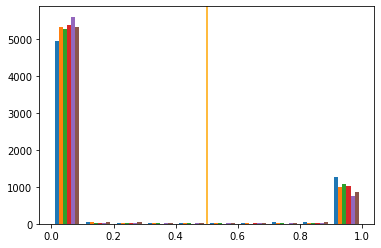

In [43]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [44]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [45]:
"{:0.2f}".format(pct_auc)

'99.82'

In [46]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [47]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [48]:
ydf.head(10)

,y_hat,y
0,"[0.001, 0.0, 0.0, 0.0, 0.0, 0.999]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 0.915, 0.084, 0.001, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.007, 0.0, 0.0, 0.0, 0.0, 0.993]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.001, 0.999, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


## Tuning process

Using `for` loops and `checkpoints` to exhaustively search for the best hyperparameters is very time consuming. Therefore, we use the `keras-tuner` module to randomly search for the best model.

In [49]:
#hyperparams to tune

layers_number = [2, 3]

# pooling layer parameters
maxpooling_pool_size = [2, 4, 8]
avepooling_pool_size = [2, 4, 8]


# convolutional layer architecture:
n_conv_1 = [128, 256, 512] # filters, a.k.a. kernels
k_conv_1 = [3, 5, 7] # kernel length
n_conv_2 = [128, 256, 512]
k_conv_2 = [3, 5, 7] # kernel length
n_conv_3 = [128, 256, 512] # filters, a.k.a. kernels
k_conv_3 = [3, 5, 7] # kernel length

# dense layer architecture: 
n_dense_1 = [256, 512, 1024]
dropout_1 = [0.2, 0.3, 0.4]
n_dense_2 = [256, 512, 1024]
dropout_2 = [0.2, 0.3, 0.4]

# training:
epochs = 60
batch_size = [256, 128]
2*3*3*3*3*3*3*3*3*3*3*3*3*2, "models to train!"

(2125764, 'models to train!')

In [55]:
# define kerastuner hyper parameters
hp = kt.HyperParameters()

kt_max_pooling = hp.Int(name='maxpooling', min_value=2, max_value=10, step=2)
kt_ave_pooling = hp.Int('avepooling', min_value=2, max_value=10, step=2)
kt_n_conv_1 = hp.Int('n_conv_1', min_value = 128, max_value= 1024, step = 256)
kt_k_conv_1 = hp.Int('k_conv_1', min_value = 2, max_value= 10, step = 2)
kt_n_conv_2 = hp.Int('n_conv_2', min_value = 128, max_value= 1024, step = 256)
kt_k_conv_2 = hp.Int('k_conv_2', min_value = 2, max_value= 10, step = 2)
kt_n_conv_3 = hp.Int('n_conv_3', min_value = 128, max_value= 1024, step = 256)
kt_k_conv_3 = hp.Int('k_conv_3', min_value = 2, max_value= 10, step = 2)
kt_activation = hp.Choice('activation', values = ['relu','elu'])
kt_n_dense_1 = hp.Int('n_dense_1', min_value = 128, max_value= 1024, step = 256)
kt_dropout_1 = hp.Choice('dropout_1', values= [0.2, 0.3, 0.4])
kt_n_dense_2 = hp.Int('n_dense_2', min_value = 128, max_value= 1024, step = 256)
kt_dropout_2 = hp.Choice('dropout_2', values= [0.2, 0.3, 0.4, 0.5])
kt_batch_size = hp.Choice('batch_size', values= [128, 256])
kt_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
kt_optimizer = hp.Choice('optimizer', values=['adam', 'nadam'])
tunning_dir = 'tunning-dir'
if not os.path.exists(tunning_dir):
    os.makedirs(tunning_dir)

In [50]:
def build_model(hp):
    model = Sequential()
    #
    model.add(Conv1D(kt_n_conv_1, kt_k_conv_1, activation=kt_activation, input_shape=input_shape[1:]))
    model.add(MaxPool1D(pool_size = kt_max_pooling))
    model.add(Conv1D(kt_n_conv_2, kt_k_conv_2, activation=kt_activation))
    model.add(AveragePooling1D(pool_size = kt_ave_pooling))
    model.add(Conv1D(kt_n_conv_3, kt_k_conv_3, activation=kt_activation))
    # model.add(GlobalMaxPooling1D())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(kt_n_dense_1, kt_activation))
    model.add(Dropout(kt_dropout_1))
    model.add(Dense(kt_n_dense_2, kt_activation))
    model.add(Dropout(kt_dropout_2))
    model.add(Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=kt_optimizer,
                  metrics=['accuracy'])
    return model

In [51]:
tuner = kt.RandomSearch(build_model,
                        objective = 'val_accuracy', 
                        max_trials = 1,
                        directory = tunning_dir,
                        project_name = 'CNN_tunning') 

modelcheckpoint = ModelCheckpoint(filepath=tunning_dir, save_best_only=True)

NameError: name 'tunning_dir' is not defined

In [ ]:
tuner.search_space_summary()


In [ ]:
tuner.search(X_train, y_train, epochs = epochs, validation_data = (X_valid, y_valid),
            callbacks=[modelcheckpoint])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 2)[0]
best_model = tuner.get_best_models(1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")